In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import radon, iradon
from scipy.io import loadmat
from scipy.stats import poisson
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import cv2
import pandas as pd
# from skimage.metrics import mean_squared_error as mse
# from skimage.metrics import peak_signal_noise_ratio as psnr
# from skimage.metrics import structural_similarity as ssim

from ART import ART, worker, get_errors
import scienceplots

plt.style.use(['science', 'notebook', 'grid'])

## EJERCICIO 1

Genero la reconstrucción de la imagen a partir del algoritmo ART y calculo el error cuadrático medio entre la imagen original y la reconstruida.

1.1428752


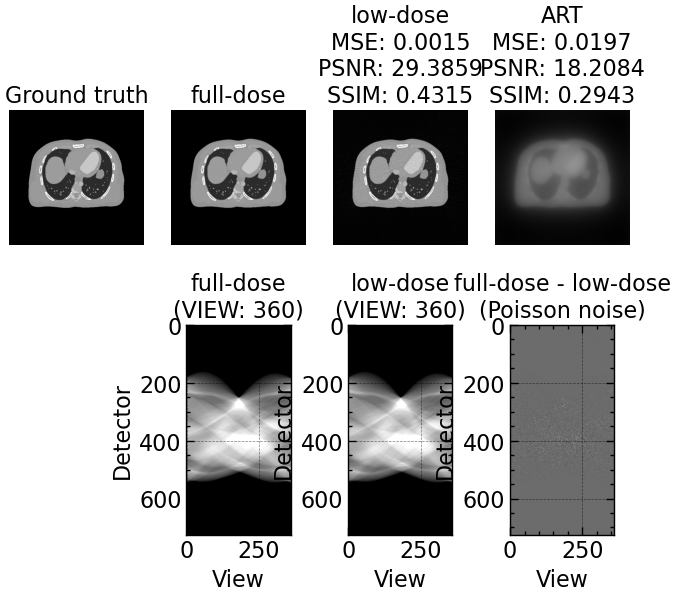

In [76]:
## SYSTEM SETTING
N = 512
ANG = 180
VIEW = 360
THETA = np.linspace(0, ANG, VIEW + 1)
THETA = THETA[:-1]

A = lambda x: radon(x, THETA, circle=False).astype(np.float32)  # Transforma en Radon
AT = lambda y: iradon(y, THETA, circle=False, filter_name=None, output_size=N).astype(np.float32)/(np.pi/(2*len(THETA))) # Transforma en Radon inverso y normaliza por pi/2Ntheta, sin filtro
AINV = lambda y: iradon(y, THETA, circle=False, output_size=N).astype(np.float32)   # Transforma en Radon inverso sin normalizar y con un filtro de rampa


## DATA GENERATION
x = loadmat('XCAT512.mat')['XCAT512']   # matriz de 512x512 con la imagen original
p = A(x)    # Sinograma de la imagen original
x_full = AINV(p)    # Imagen reconstruida con el sinograma p

## LOW-DOSE SINOGRAM GENERATION
i0 = 5e4
pn = np.exp(-p)
pn = i0*pn
pn = poisson.rvs(pn)
pn[pn < 1] = 1
pn = -np.log(pn/i0)
pn[pn < 0] = 0  # clipeo los valores negativos

y = pn  # Sinograma de la imagen

# plt.imshow(y, cmap='gray', aspect='auto')

## Algebraic Reconstruction Technique (ART) INITIALIZATION
x_low = AINV(y)
x0 = np.zeros_like(x)
mu = 1e0
niter = 5
bpos = True

x_art = ART(A, AT, y, x0, mu, niter, bpos)

## CALCULATE QUANTIFICATION FACTOR
x_low[x_low < 0] = 0
x_art[x_art < 0] = 0
nor = np.amax(x)

mse_x_low = mse(x/nor, x_low/nor)
mse_x_art = mse(x/nor, x_art/nor)

data_range = max((x/nor).max(), (x_low/nor).max(), (x_art/nor).max()) - min((x/nor).min(), (x_low/nor).min(), (x_art/nor).min())
print(data_range)

psnr_x_low = psnr(x/nor, x_low/nor, data_range=data_range)
psnr_x_art = psnr(x/nor, x_art/nor, data_range=data_range)

ssim_x_low = ssim(x_low/nor, x/nor, data_range=data_range)
ssim_x_art = ssim(x_art/nor, x/nor, data_range=data_range)

## DISPLAY
wndImg = [0, 0.03]
wndPrj = [0, 6]

plt.subplot(241)
plt.imshow(x, cmap='gray', vmin=wndImg[0], vmax=wndImg[1])
plt.axis('off')
plt.axis('image')
plt.title('Ground truth')

plt.subplot(242)
plt.imshow(x_full, cmap='gray', vmin=wndImg[0], vmax=wndImg[1])
plt.axis('off')
plt.axis('image')
plt.title('full-dose')

plt.subplot(243)
plt.imshow(x_low, cmap='gray', vmin=wndImg[0], vmax=wndImg[1])
plt.axis('off')
plt.axis('image')
plt.title('low-dose\nMSE: %.4f\nPSNR: %.4f\nSSIM: %.4f' % (mse_x_low, psnr_x_low, ssim_x_low))

plt.subplot(244)
plt.imshow(x_art, cmap='gray', vmin=wndImg[0], vmax=wndImg[1])
plt.axis('off')
plt.axis('image')
plt.title('ART\nMSE: %.4f\nPSNR: %.4f\nSSIM: %.4f' % (mse_x_art, psnr_x_art, ssim_x_art))

plt.subplot(246)
plt.imshow(p, cmap='gray', vmin=wndPrj[0], vmax=wndPrj[1])
plt.title('full-dose\n(VIEW: %d)' % VIEW)
plt.xlabel('View')
plt.ylabel('Detector')

plt.subplot(247)
plt.imshow(y, cmap='gray', vmin=wndPrj[0], vmax=wndPrj[1])
plt.title('low-dose\n(VIEW: %d)' % VIEW)
plt.xlabel('View')
plt.ylabel('Detector')

plt.subplot(248)
plt.imshow(y - p, cmap='gray')
plt.title('full-dose - low-dose\n(Poisson noise)')
plt.xlabel('View')
plt.ylabel('Detector')

plt.show()


## EJERCICIO 2

Analisis del nivel de ruido segun el numero de angulos, detectores y del nivel de ruido.

In [2]:
# def get_errors(x, n_angles, N_deetctors, noise,  niter, mu, bpos):
#     THETA = np.linspace(0, 180, n_angles + 1)
#     THETA = THETA[:-1]
#     N = N_deetctors

#     x = cv2.resize(x, (N, N), interpolation=cv2.INTER_LINEAR)

#     A = lambda x: radon(x, THETA, circle=False).astype(np.float32)  # Transforma en Radon
#     AT = lambda y: iradon(y, THETA, circle=False, filter_name=None, output_size=N).astype(np.float32) / (
#                 np.pi / (2 * len(THETA)))  # Transforma en Radon inverso y normaliza por pi/2Ntheta, sin filtro
#     i0 = noise
#     pn = np.exp(-A(x))
#     pn = i0 * pn
#     pn = poisson.rvs(pn)    # agrega ruido poissoniano
#     pn[pn < 1] = 1
#     pn = -np.log(pn / i0)
#     pn[pn < 0] = 0  # clipeo los valores negativos

#     y = pn  # Sinograma de la imagen
#     x0 = np.zeros_like(x)
#     x_art = ART(A, AT, y, x0, mu, niter, bpos)
#     nor = np.amax(x)

#     mse_x_art = mse(x / nor, x_art / nor)
#     data_range = max((x / nor).max(), (x_art / nor).max()) - min((x / nor).min(), (x_art / nor).min())
#     psnr_x_art = psnr(x / nor, x_art / nor, data_range=data_range)
#     ssim_x_art = ssim(x_art / nor, x / nor, data_range=data_range)

#     return mse_x_art, psnr_x_art, ssim_x_art

 Dejo el nivel de ruido fijo y vario los demas parametros

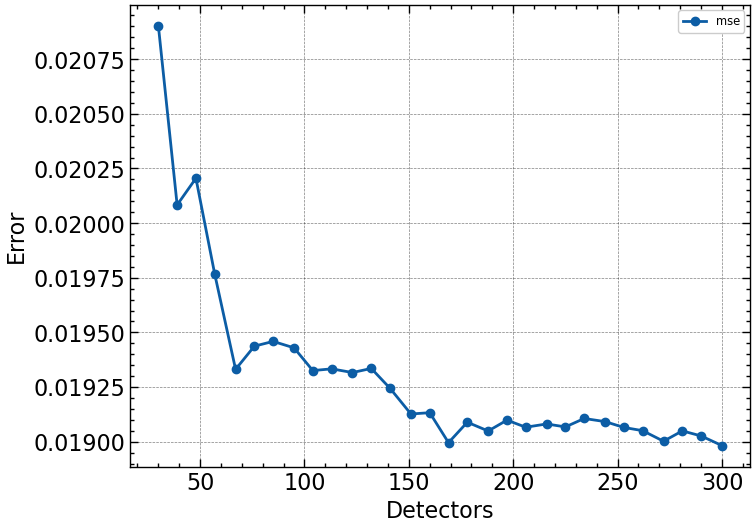

In [2]:
N_sim = 30

views = np.linspace(30, 100, N_sim, dtype=int)
detectors = np.linspace(30, 300, N_sim, dtype=int)

dect_fijo = 512
view_fijo = 360

niter = 5

# Creo los dos diccionarios en donde gauradar los datos
restults_detecs = {'mse': [], 'psnr': [], 'ssim': []}
restults_angles = {'mse': [], 'psnr': [], 'ssim': []}

x = loadmat('XCAT512.mat')['XCAT512']   # matriz de 512x512 con la imagen original

for detc, view in zip(detectors, views):
    mse_x_art, psnr_x_art, ssim_x_art = get_errors(x, view_fijo, detc, 5e4, niter=niter)
    restults_detecs['mse'].append(mse_x_art)
    restults_detecs['psnr'].append(psnr_x_art)
    restults_detecs['ssim'].append(ssim_x_art)

    # mse_x_art, psnr_x_art, ssim_x_art = get_errors(x, view, dect_fijo, 5e4, 5, 1e0, True)
    # restults_angles['mse'].append(mse_x_art)
    # restults_angles['psnr'].append(psnr_x_art)
    # restults_angles['ssim'].append(ssim_x_art)

# Ploteo resultados
plt.figure()
plt.plot(detectors, restults_detecs['mse'], '-o', label='mse')
# plt.plot(detectors, restults_detecs['psnr'], label='psnr')
# plt.plot(detectors, restults_detecs['ssim'], label='ssim')
plt.xlabel('Detectors')
plt.ylabel('Error')
plt.legend(fontsize='small')
plt.show()

# plt.figure()
# plt.plot(views, restults_angles['mse'], label='mse')
# # plt.plot(views, restults_angles['psnr'], label='psnr')
# # plt.plot(views, restults_angles['ssim'], label='ssim')
# plt.xlabel('Views')
# plt.ylabel('Error')
# plt.legend(fontsize='small')
# plt.show()


In [2]:
import multiprocessing as mp

def get_error_dir_angles(x, views, detectors, detec_fijo, view_fijo, noise, niter=2):
    # Creo los dos diccionarios en donde gauradar los datos
    results_detecs = {'mse': [], 'psnr': [], 'ssim': []}
    results_angles = {'mse': [], 'psnr': [], 'ssim': []}

    with mp.Pool(mp.cpu_count()) as pool:
        results = pool.map(worker, [(x, view_fijo, detc, noise, niter) for detc in detectors])
        for mse, psnr, ssim in results:
            results_detecs['mse'].append(mse)
            results_detecs['psnr'].append(psnr)
            results_detecs['ssim'].append(ssim)

        results = pool.map(worker, [(x, view, detec_fijo, noise, niter) for view in views])
        for mse, psnr, ssim in results:
            results_angles['mse'].append(mse)
            results_angles['psnr'].append(psnr)
            results_angles['ssim'].append(ssim)

    return results_detecs, results_angles

def to_DF(results_noise, noises, detec_fijo, view_fijo, detectors, views):
    dict_dects = {'noise': [], 'detectors': [], 'mse': [], 'psnr': [], 'ssim': [], 'view_fijo': []}
    dict_angles = {'noise': [], 'views': [], 'mse': [], 'psnr': [], 'ssim': [], 'detec_fijo': []}
    dict_dects['view_fijo'] = view_fijo
    dict_angles['detec_fijo'] = detec_fijo
    
    for i, (results_detecs, results_angles) in enumerate(results_noise):
        for j, detec in enumerate(detectors):
            dict_dects['noise'].append(noises[i])
            dict_dects['detectors'].append(detec)
            dict_dects['mse'].append(results_detecs['mse'][j])
            dict_dects['psnr'].append(results_detecs['psnr'][j])
            dict_dects['ssim'].append(results_detecs['ssim'][j])

        for j, view in enumerate(views):
            dict_angles['noise'].append(noises[i])
            dict_angles['views'].append(view)
            dict_angles['mse'].append(results_angles['mse'][j])
            dict_angles['psnr'].append(results_angles['psnr'][j])
            dict_angles['ssim'].append(results_angles['ssim'][j])
            
    return pd.DataFrame(dict_dects), pd.DataFrame(dict_angles)

In [6]:
N_sim = 25

views = np.linspace(30, 600, N_sim, dtype=int)
detectors = np.linspace(30, 1000, N_sim, dtype=int)

dect_fijo = 512
view_fijo = 360
path_detectores ='./resultados/noise_detectores_ART_low_noise_range_1_20.csv'
path_angulos = './resultados/noise_angulos_ART_low_noise_range_1_20.csv'

# Creo los dos diccionarios en donde gauradar los datos

x = loadmat('XCAT512.mat')['XCAT512']   # matriz de 512x512 con la imagen original

N_noise = 20
noises = np.linspace(1e2, 1e5, N_noise)
niter = 10

results_noise = []

for noise in noises:
    print("Noise: ", noise)
    results_detecs, results_angles = get_error_dir_angles(x, views, detectors, dect_fijo, view_fijo, noise, niter)
    results_noise.append((results_detecs, results_angles))
print('Done!')

df_detecs, df_angles = to_DF(results_noise, noises, dect_fijo, view_fijo, detectors, views)
df_detecs.to_csv(path_detectores, index=False)
df_angles.to_csv(path_angulos, index=False)

Noise:  100.0
Noise:  5357.894736842105
Noise:  10615.78947368421
Noise:  15873.684210526315


KeyboardInterrupt: 

25


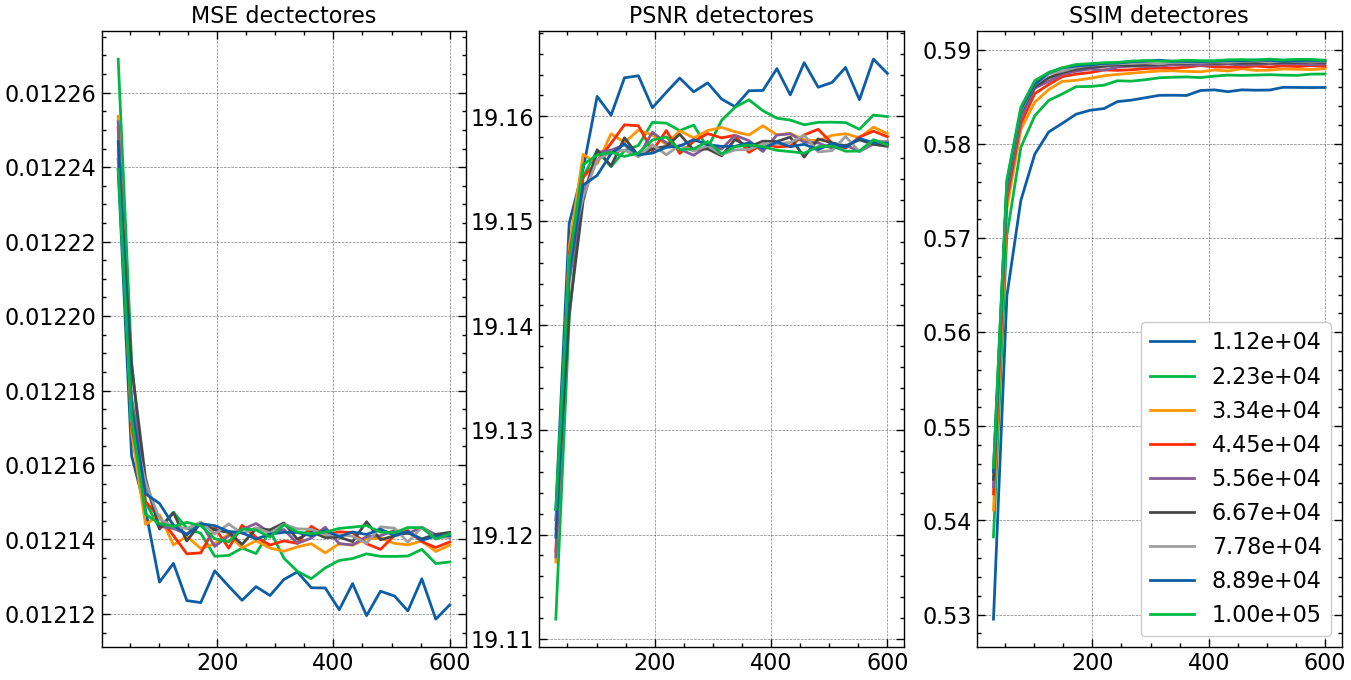

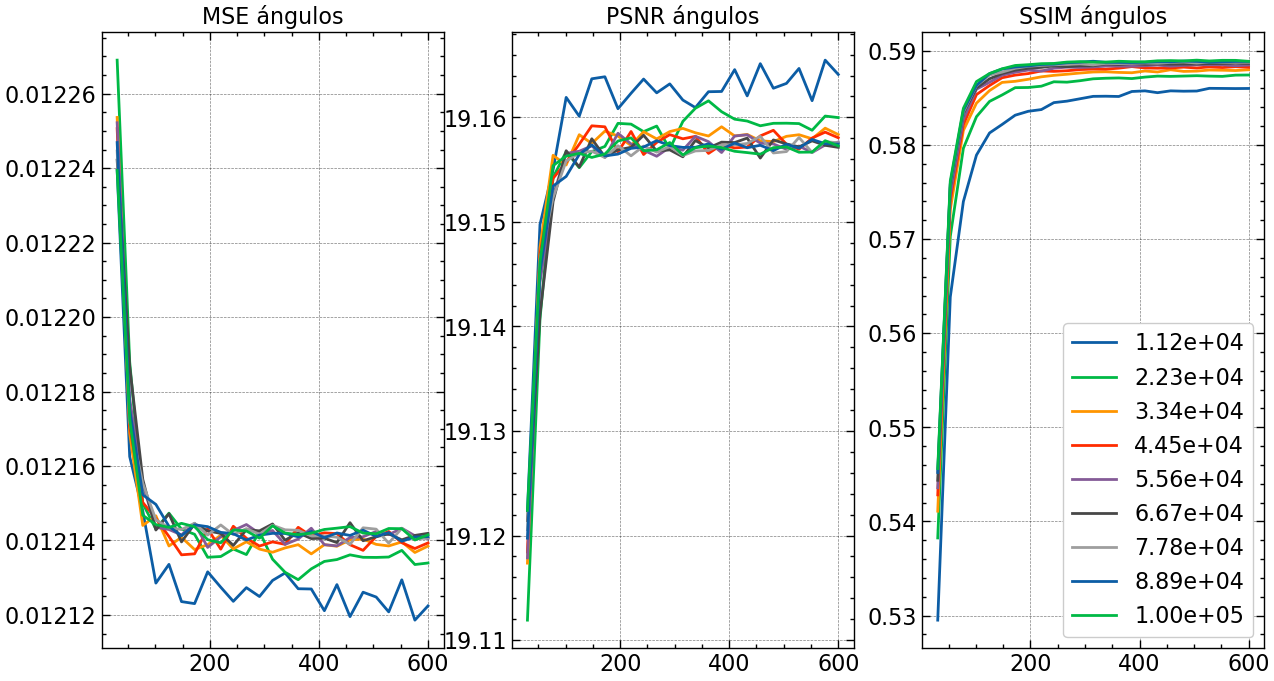

In [5]:
r = np.array(results_noise)
print(len(results_noise[1][1]['mse']))

r_dec = r[:, 0]
r_dec = r[:, 1]

for i in range(len(r_dec)):
    if i == 0:
        continue
    plt.figure(1, figsize=(16, 8))
    plt.subplot(1, 3, 1)
    plt.title('MSE dectectores')
    plt.plot(detectors, r_dec[i]['mse'], label=f'{noises[i]:.2e}')
    plt.subplot(1, 3, 2)
    plt.title('PSNR detectores')
    plt.plot(detectors, r_dec[i]['psnr'], label=f'{noises[i]:.2e}')
    plt.subplot(1, 3, 3)
    plt.title('SSIM detectores')
    plt.plot(detectors, r_dec[i]['ssim'], label=f'{noises[i]:.2e}')
    plt.legend()

    plt.figure(2, figsize=(15, 8))
    plt.subplot(1, 3, 1)
    plt.title('MSE ángulos')
    plt.plot(views, r_dec[i]['mse'], label=f'{noises[i]:.2e}')
    plt.subplot(1, 3, 2)
    plt.title('PSNR ángulos')
    plt.plot(views, r_dec[i]['psnr'], label=f'{noises[i]:.2e}')
    plt.subplot(1, 3, 3)
    plt.title('SSIM ángulos')
    plt.plot(views, r_dec[i]['ssim'], label=f'{noises[i]:.2e}')
    plt.legend()

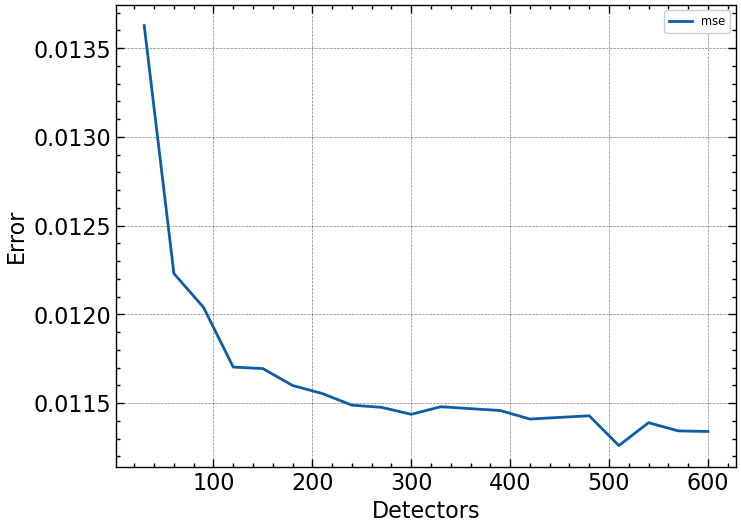

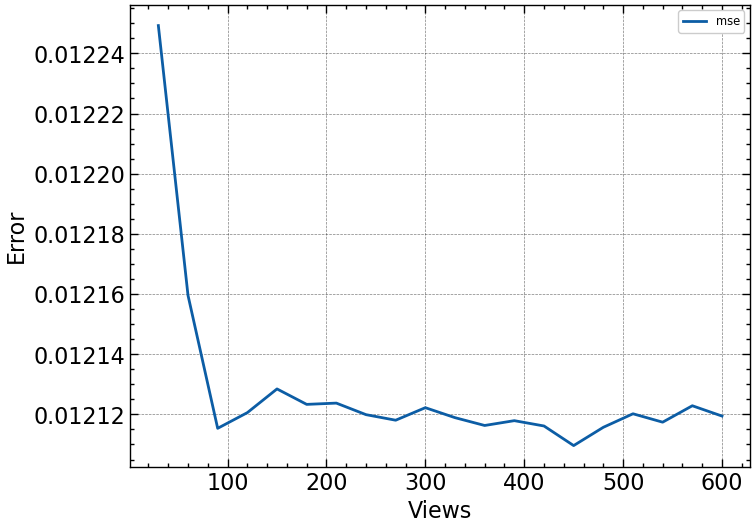

In [43]:
N_sim = 20

views = np.linspace(30, 600, N_sim, dtype=int)
detectors = np.linspace(30, 600, N_sim, dtype=int)

dect_fijo = 512
view_fijo = 360

# Creo los dos diccionarios en donde gauradar los datos

x = loadmat('XCAT512.mat')['XCAT512']   # matriz de 512x512 con la imagen original

N_noise = 4
noises = np.linspace(1e3, 1e6, N_noise)
noise = 1e4
niter = 10

results_detecs, results_angles = get_error_dir_angles(x, views, detectors, dect_fijo, view_fijo, noise, niter)

# Ploteo resultados
plt.figure()
plt.plot(detectors, results_detecs['mse'], label='mse')
# plt.plot(detectors, results_detecs['psnr'], label='psnr')
# plt.plot(detectors, results_detecs['ssim'], label='ssim')
plt.xlabel('Detectors')
plt.ylabel('Error')
plt.legend(fontsize='small')
plt.show()

plt.figure()
plt.plot(views, results_angles['mse'], label='mse')
# plt.plot(views, results_angles['psnr'], label='psnr')
# plt.plot(views, results_angles['ssim'], label='ssim')
plt.xlabel('Views')
plt.ylabel('Error')
plt.legend(fontsize='small')
plt.show()

In [16]:
import multiprocessing as mp

N_sim = 20

views = np.linspace(30, 600, N_sim, dtype=int)
detectors = np.linspace(30, 600, N_sim, dtype=int)

dect_fijo = 512
view_fijo = 360

# Creo los dos diccionarios en donde gauradar los datos
results_detecs = {'mse': [], 'psnr': [], 'ssim': []}
results_angles = {'mse': [], 'psnr': [], 'ssim': []}
result_noise = []

x = loadmat('XCAT512.mat')['XCAT512']   # matriz de 512x512 con la imagen original

N_noise = 4
noises = np.linspace(1e3, 1e6, N_noise)
noise = 1e4
niter = 10
# for noise in noises:
with mp.Pool(mp.cpu_count()) as pool:
    results = pool.map(worker, [(x, view_fijo, detc, noise, niter) for detc in detectors])
    for mse, psnr, ssim in results:
        results_detecs['mse'].append(mse)
        results_detecs['psnr'].append(psnr)
        results_detecs['ssim'].append(ssim)

    results = pool.map(worker, [(x, view, dect_fijo, noise, niter) for view in views])
    for mse, psnr, ssim in results:
        results_angles['mse'].append(mse)
        results_angles['psnr'].append(psnr)
        results_angles['ssim'].append(ssim)

# result_noise.append([results_detecs, results_angles])



In [41]:
len([view for view in views])

20

#### Ploteo tanto mse, psnr, ssim para cada nivel de ruido y para cada experimento (n angulos y n detectores)

In [39]:
# result_noise_vect = np.array(result_noise)

# result_noise_detecs = result_noise[:, 0]
# result_noise_angles = result_noise[:, 1]

# print(len(result_noise_angles[0]['mse']))

# plt.plot(detectors,result_noise_angles[0]['mse'])

print(result_noise[0][0]['mse'])

# Ploteo resultados
# for i in range(len(result_noise_vect)):
#     plt.figure(1, figsize=(12, 6))
#     plt.subplot(1, 3, 1)
#     plt.plot(detectors, result_noise_detecs[i]['mse'], label='mse')
#     plt.subplot(1, 3, 2)
#     plt.plot(detectors, result_noise_detecs[i]['psnr'], label='psnr')
#     plt.subplot(1, 3, 3)
#     plt.plot(detectors, result_noise_detecs[i]['ssim'], label='ssim')

#     plt.figure(2, figsize=(12, 6))
#     plt.subplot(1, 3, 1)
#     plt.plot(views, result_noise_angles[i]['mse'], label='mse')
#     plt.subplot(1, 3, 2)
#     plt.plot(views, result_noise_angles[i]['psnr'], label='psnr')
#     plt.subplot(1, 3, 3)
#     plt.plot(views, result_noise_angles[i]['ssim'], label='ssim')
    

[0.014412243743965606, 0.012511801593221102, 0.012233164635759998, 0.011807380448826624, 0.011779306376476322, 0.011633975023960644, 0.011608460108646329, 0.011529632181929558, 0.011512833953190317, 0.011449971718596352, 0.011459890863968387, 0.011427305597746818, 0.011418040816290527, 0.011326615833922561, 0.011300557989823568, 0.011270176966257801, 0.011099324946958512, 0.011301094787580325, 0.011420512112259867, 0.01171284450683741, 0.013438824408682904, 0.012142660271248478, 0.01199437299785335, 0.011666691654603396, 0.011658402184814644, 0.011580015295991898, 0.011536568668302319, 0.011466436955849747, 0.011464501230775036, 0.01142673065120327, 0.011470575656781024, 0.011467652985969072, 0.011455599414762055, 0.011416499521349944, 0.011424414254057843, 0.011441341615361925, 0.011278655351745234, 0.011422676878767987, 0.011390563221668537, 0.011409856815181993, 0.013444049826184547, 0.012147102475034654, 0.01199258346698074, 0.011665313472730816, 0.011657659897247845, 0.01157856115

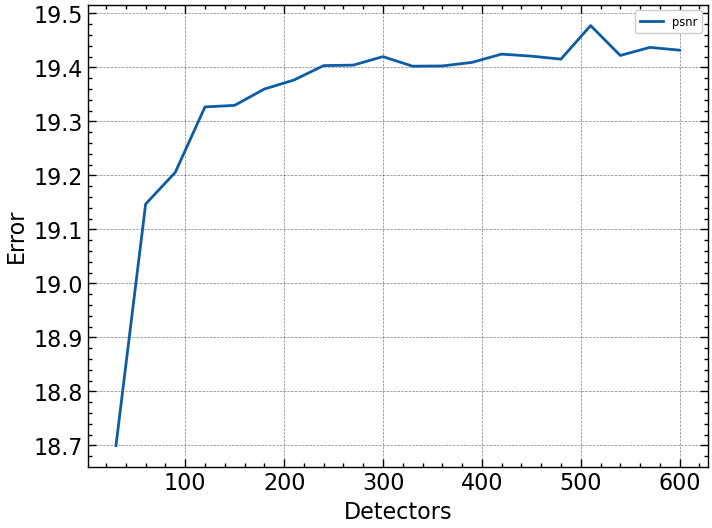

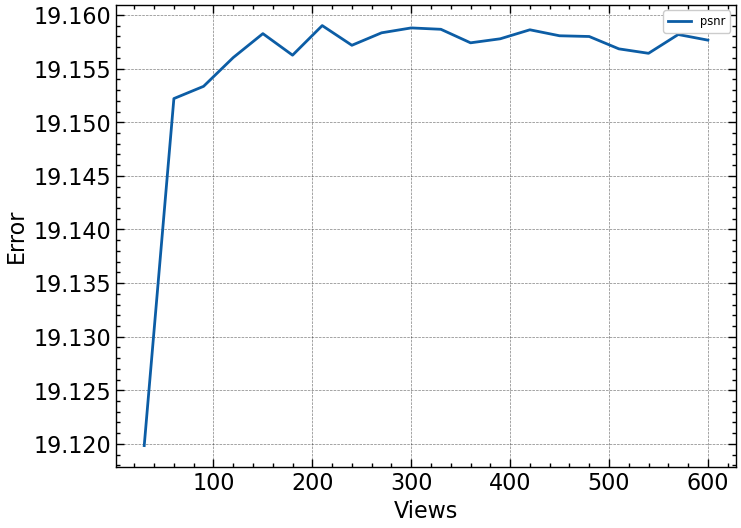

In [15]:
plt.figure()
# plt.plot(detectors, results_detecs['mse'], label='mse')
plt.plot(detectors, results_detecs['psnr'], label='psnr')
# plt.plot(detectors, results_detecs['ssim'], label='ssim')
plt.xlabel('Detectors')
plt.ylabel('Error')
plt.legend(fontsize='small')
plt.show()

plt.figure()
# plt.plot(views, results_angles['mse'], label='mse')
plt.plot(views, results_angles['psnr'], label='psnr')
# plt.plot(views, results_angles['ssim'], label='ssim')
plt.xlabel('Views')
plt.ylabel('Error')
plt.legend(fontsize='small')
plt.show()
